In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import os
import os.path
import random as pyr
import sys
import tarfile
import argparse
import re
import simplejson
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib as mpl
import pprint
import tarfile
import time
from collections import Counter
import skimage

In [4]:
cocotext = simplejson.load(open("cocotext.v2.json"))
imgs = {int(k): v for k, v in cocotext["imgs"].items()}
anns = {int(k): v for k, v in cocotext["anns"].items()}
for a in anns.values():
    a.update(imgs[a["image_id"]])
print({a["image_id"] for a in anns.values()} - set(imgs.keys()))
print({a["legibility"] for a in anns.values()})
print({a["set"] for a in anns.values()})

set()
{'illegible', 'legible'}
{'train', 'val'}


In [17]:
def ann_test(a):
    if a["legibility"] != "legible": return False
    #if a["language"] != "english": return False
    x, y, w, h = [int(q) for q in a['bbox']]
    if len(a["utf8_string"]) < 2: return False
    if w<10: return False
    if h<5: return False
    #if h>w: return False
    return True
good = [a for a in anns.values() if ann_test(a)]
random.shuffle(good)
len(good)

60281

In [28]:
byimage = {}
for an in good:
    byimage.setdefault(an["file_name"], []).append(an)
len(byimage.keys())

15082

In [60]:
def read_image_for_annotation(an):
    s = "val" if "val" in an['file_name'] else "train"
    fname = "/data1/coco-extract/{s}2014/{f}".format(s=s, f=an['file_name'])
    image = imread(fname)
    return image
def make_mask_for_annotation(an):
    mask = an["mask"]
    points = zeros((len(mask)//2, 2))
    points[:, 0] = mask[1::2]
    points[:, 1] = mask[0::2]
    h, w = an["height"], an["width"]
    rr, cc = skimage.draw.polygon(points[:,0], points[:,1])
    rr, cc = clip(rr, 0, h-1), clip(cc, 0, w-1)
    result = zeros((h, w))
    result[rr, cc] = 1.0
    return result

In [61]:
import scipy.ndimage as ndi
import skimage.morphology
from webdataset import writer

# writing coco-detect-train-000000.tar 0 0.0 GB 0
# writing coco-detect-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000538640.jpg
1000 COCO_train2014_000000538640.jpg
2000 COCO_train2014_000000538640.jpg
3000 COCO_train2014_000000538640.jpg
4000 COCO_train2014_000000538640.jpg
5000 COCO_train2014_000000538640.jpg
6000 COCO_train2014_000000538640.jpg
7000 COCO_train2014_000000538640.jpg
8000 COCO_train2014_000000538640.jpg
9000 COCO_train2014_000000538640.jpg
10000 COCO_train2014_000000538640.jpg
11000 COCO_train2014_000000538640.jpg
12000 COCO_train2014_000000538640.jpg
13000 COCO_train2014_000000538640.jpg
14000 COCO_train2014_000000538640.jpg
15000 COCO_train2014_000000538640.jpg


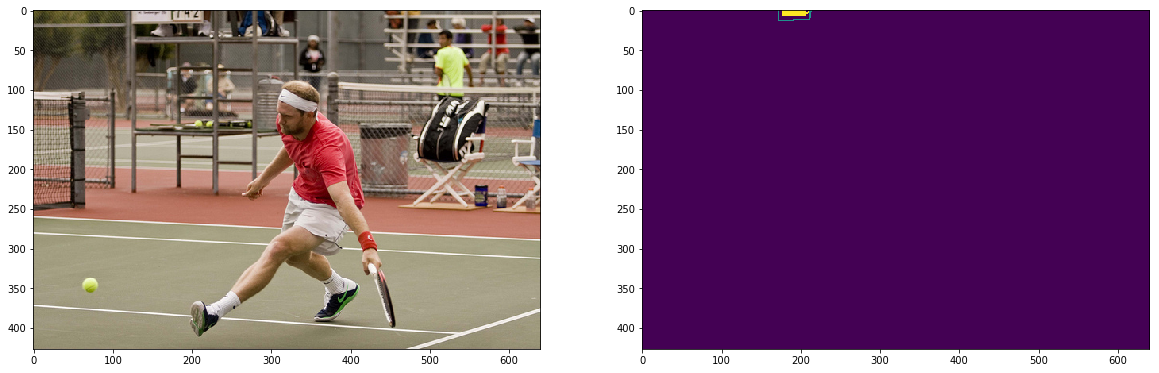

In [63]:
train = writer.ShardWriter("coco-detect-train-%06d.tar", maxsize=9e9)
val = writer.ShardWriter("coco-detect-val-%06d.tar", maxsize=9e9)

index = 0
for image, anns in byimage.items():
    image = read_image_for_annotation(anns[0])
    masks = [make_mask_for_annotation(a) for a in anns]
    boundaries = []
    for mask in masks:
        outer = ndi.maximum_filter(mask, 5)
        boundary = outer-mask
        boundaries.append(boundary)
    boundaries = amax(array(boundaries), axis=0)
    seeds = []
    for mask in masks:
        inner = ndi.minimum_filter(mask, 9)
        skel = minimum(ndi.minimum_filter(mask, 4), ndi.maximum_filter(skimage.morphology.skeletonize(mask), 2))
        inner = maximum(inner, skel)
        seeds.append(inner)
    seeds = amax(array(seeds), axis=0)
    result = zeros(image.shape[:2]+(3,), "uint8")
    result[:,:,0] = maximum(boundaries, 2*seeds)
    sample = dict(__key__=an["file_name"], jpg=image, png=result)
    if an["set"]=="val":
        val.write(sample)
    else:
        train.write(sample)
    if index%1000==0: print(index, an["file_name"], file=sys.stderr)
    index += 1
    
train.close()
val.close()

figsize(20,10)
subplot(121); imshow(image)
subplot(122); imshow(result[:,:,0]*0.5)